# Using `Sparse3D`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sparse3d import Sparse3D

from scipy import sparse

Let's imagine a scenario where we are trying to model a large astronomy image. Let's set up some image dimensions, and a number of targets to model.

We'll need to have some model for the source shape. Let's pick a simple 2D Gaussian for now, with a standard deviation of 2 pixels. 

In [2]:
imshape = (1024, 1024)
nsources = 50000
source_brightness = 10**np.random.normal(0, 1.5, size=nsources)# * 10
source_row, source_col = np.random.uniform(0, 1024, size=(nsources, 2)).T
sigma = 1

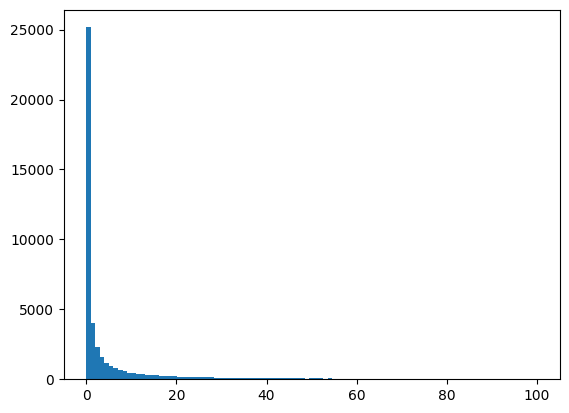

In [3]:
plt.hist(source_brightness, np.linspace(0, 100, 100));

If we want to model this, we have to

1. Create a model for each source
2. Add the sources together

This will require that we evaluate the Gaussian function for 50000 sources, and evaluate it out to some distance. If we try to calculate the full model across all the pixels possible we will end up with a very slow calculation. 

Let's use Sparse3D to calculate it.

First let's decide how far out from each source we want to evaulate the model. Given that we're going to use a Gaussian, we'll go out 5 standard deviations from each side.

In [4]:
subimage_size = sigma * 5 * 2

We need the indices in row and column for each sub image around a star. This needs to be in integer, pixel positions. 

We're obtain the integer row and column position for each source, and then the phase in that pixel.

In [5]:
source_row_int, source_row_phase = np.floor(source_row).astype(int), source_row % 1
source_col_int, source_col_phase = np.floor(source_col).astype(int), source_col % 1

Then we can create the grid of pixel offsets

In [6]:
R, C = np.mgrid[:subimage_size, :subimage_size] - subimage_size//2

In [7]:
R

array([[-5, -5, -5, -5, -5, -5, -5, -5, -5, -5],
       [-4, -4, -4, -4, -4, -4, -4, -4, -4, -4],
       [-3, -3, -3, -3, -3, -3, -3, -3, -3, -3],
       [-2, -2, -2, -2, -2, -2, -2, -2, -2, -2],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       [ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2],
       [ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3],
       [ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4]])

In [8]:
R.shape

(10, 10)

This defines the pixel indices in our sub array. 

The integer row and column position in 3D for **each source** is then given as

In [9]:
row3d = R[:, :, None] + source_row_int
col3d = C[:, :, None] + source_col_int

In [10]:
row3d.shape

(10, 10, 50000)

We can see that the shape of this array is (10, 10, 100000) which is (nrows, ncolumns, nsources).

If we look at the first source we get

In [11]:
row3d[:, :, 0]

array([[488, 488, 488, 488, 488, 488, 488, 488, 488, 488],
       [489, 489, 489, 489, 489, 489, 489, 489, 489, 489],
       [490, 490, 490, 490, 490, 490, 490, 490, 490, 490],
       [491, 491, 491, 491, 491, 491, 491, 491, 491, 491],
       [492, 492, 492, 492, 492, 492, 492, 492, 492, 492],
       [493, 493, 493, 493, 493, 493, 493, 493, 493, 493],
       [494, 494, 494, 494, 494, 494, 494, 494, 494, 494],
       [495, 495, 495, 495, 495, 495, 495, 495, 495, 495],
       [496, 496, 496, 496, 496, 496, 496, 496, 496, 496],
       [497, 497, 497, 497, 497, 497, 497, 497, 497, 497]])

i.e. the row position for the first source.

We need to build our model. Our model is given as

$$
f(x, y) = \frac{1}{2 \pi \sigma_x \sigma_y} \exp \left( -\frac{1}{2} \left( \frac{(x - \mu_x)^2}{\sigma_x^2} + \frac{(y - \mu_y)^2}{\sigma_y^2} \right) \right)
$$

where $dx$ and $dy$ indicate the distance from the source position in x and y.

Let's create arrays for both the $x$ and $y$ terms

In [12]:
x3d = R[:, :, None] * np.ones(nsources)
y3d = C[:, :, None] * np.ones(nsources)

In [13]:
X = Sparse3D(data=x3d, row=row3d, col=col3d, imshape=imshape)
Y = Sparse3D(data=y3d, row=row3d, col=col3d, imshape=imshape)

In [14]:
X

<(1024, 1024, 50000) Sparse3D array of type float64>

In [15]:
l = np.exp(-0.5*((X - source_row_phase)**2/sigma**2 + (Y - source_col_phase)**2/sigma**2)) * 1/(2*np.pi * sigma**2)

In [18]:
model_image = l.dot(source_brightness)

[Text(0.5, 0, 'Column'), Text(0, 0.5, 'Row'), Text(0.5, 1.0, 'Model Image')]

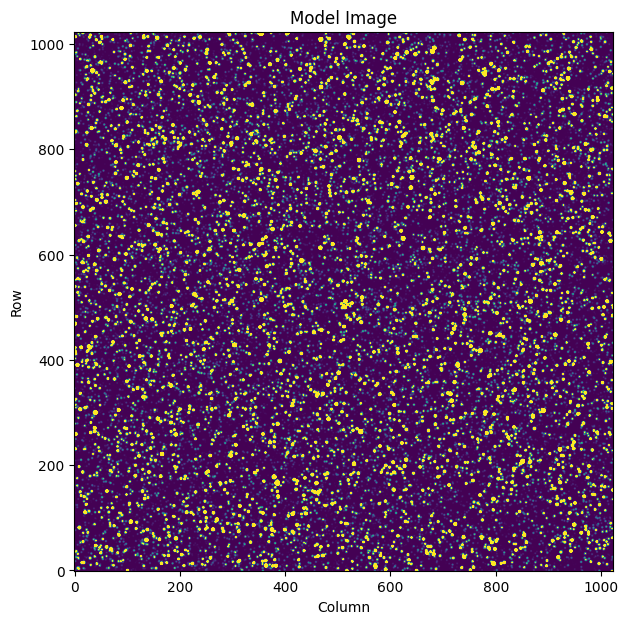

In [19]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(model_image, vmin=0, vmax=10, origin='lower');
ax.set(xlabel='Column', ylabel='Row', title='Model Image')

Let's try imagining this is real data. We can add some noise, and then use our matrix to fit the data.

In [20]:
fake_data = np.random.poisson(model_image) + np.random.normal(0, 3, size=model_image.shape).astype(int)

In this contrived case, I have a perfect model for the data, let's extract the flux for these targets.

We'll fit this by converting our Sparse3D matrix to a `sparse.csr_matrix` which will give us a 2D matrix

In [21]:
lc = l.tocsr()

In [22]:
l

<(1024, 1024, 50000) Sparse3D array of type float64>

In [23]:
lc

<1048576x50000 sparse matrix of type '<class 'numpy.float64'>'
	with 4975412 stored elements in Compressed Sparse Row format>

Note this new matrix has shape (npixels, nsources).

We can use simple linear algebra to fit our fake data and find the 50000 sources.

In [24]:
%%time
best_fit_weights = sparse.linalg.spsolve(lc.T.dot(lc), sparse.csc_matrix(lc.T.dot(fake_data.ravel())).T)

CPU times: user 1.35 s, sys: 30.5 ms, total: 1.38 s
Wall time: 1.4 s


In [25]:
len(best_fit_weights)

50000

You can see we've fit 50,000 stars in this image in less than 2 seconds.

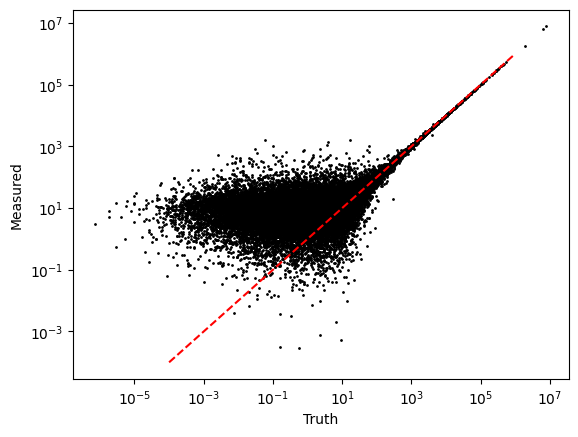

In [26]:
fig, ax = plt.subplots()
ax.scatter(source_brightness, best_fit_weights, s=1, c='k')
ax.plot([1e-4, 1e6], [1e-4, 1e6], c='r', ls='--')
ax.set(yscale='log', xscale='log', xlabel='Truth', ylabel='Measured');

Of course, in this contrived case, I know the true model. But you can see given real data and an approximate model how this can be recreated. 

## Hints 1: Efficiency

Keep in mind every operation you do on one of these objects is costing some time to remake the object.

For example
```python
Sparse3D + 1 + np.ones(10) + 324
```

is less efficient than
```python
Sparse3D + (1 + np.ones(10) + 324)
```

so you can improve efficiency by calculating as much as you can in numpy, then casting into a `Sparse3D` object

In [27]:
dX1 = Sparse3D(-0.5 * (x3d - source_row_phase)**2/sigma**2, row3d, col3d, imshape=imshape)
dY1 = Sparse3D(-0.5 * (y3d - source_col_phase)**2/sigma**2, row3d, col3d, imshape=imshape)

In [28]:
l = np.exp(dX1 + dY1) * (1/(2*np.pi * sigma**2))

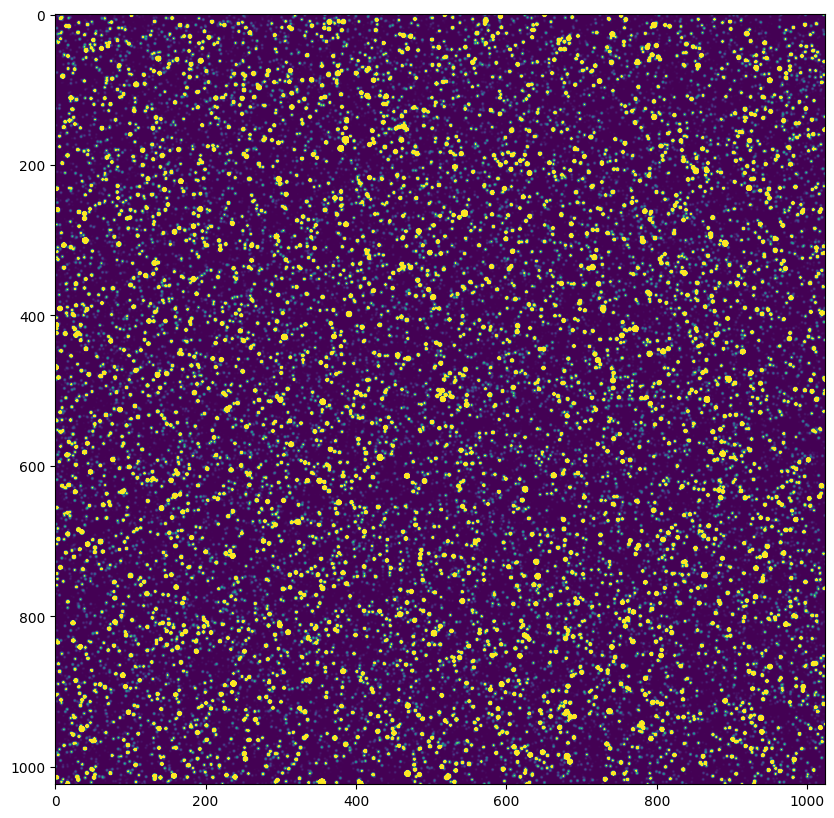

In [30]:
plt.figure(figsize=(10, 10))
plt.imshow(l.dot(source_brightness), vmin=0, vmax=10);